In [797]:
# ライブラリーのインポート
import warnings
warnings.filterwarnings('ignore')

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from plotly import tools
from plotly.graph_objs import Bar, Figure, Layout, Scatter
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [798]:
import plotly
init_notebook_mode(connected=True)
save_image = None # 'png' if save image

df = pd.read_csv('./train/PAC_Total_1412.csv')


In [799]:
df=df[['Date','amount']]
df.head()

,Date,amount
0,2010/1/1,105639.2912
1,2010/2/1,111807.9553
2,2010/3/1,146829.8900
3,2010/4/1,103340.4407
4,2010/5/1,123905.1050


In [800]:
# float型に変換
df['amount'] = df['amount'].astype('float64')
# datetime型にしてインデックスにする
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")


In [801]:
df.head()

,amount
Date,
2010-01-01,105639.2912
2010-02-01,111807.9553
2010-03-01,146829.8900
2010-04-01,103340.4407
2010-05-01,123905.1050


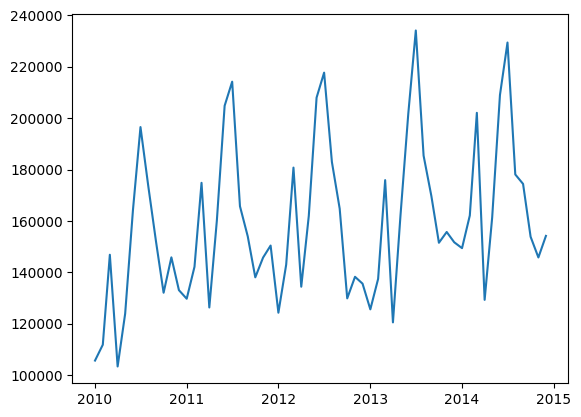

In [802]:
# データの可視化
plt.plot(df.amount)
plt.show()

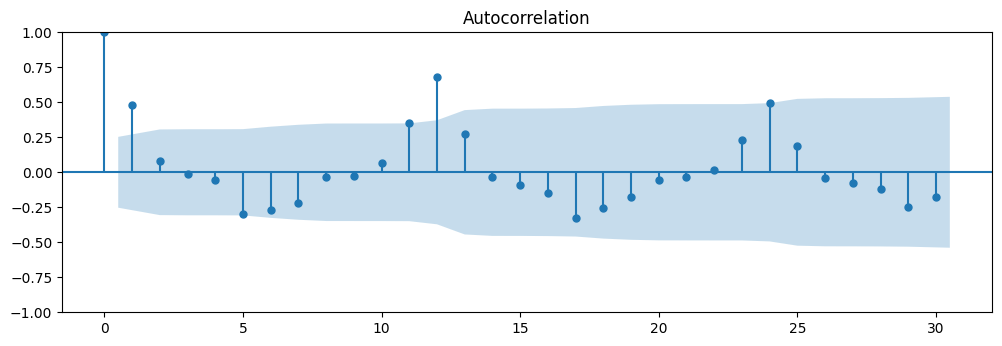

In [803]:
# コレログラム
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.amount, lags=30, ax=ax1)


In [804]:
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.amount, lags=20, ax=ax2)   #出ない

In [805]:
res = sm.tsa.stattools.adfuller(df.amount)
print('p-value = {:.4}'.format(res[1]))
#p-value = 0.9919
#Passengers: p-value > 0.1なので有意水準10%で帰無仮説（定常性を満たす）は棄却されず、定常ではない

p-value = 0.07452


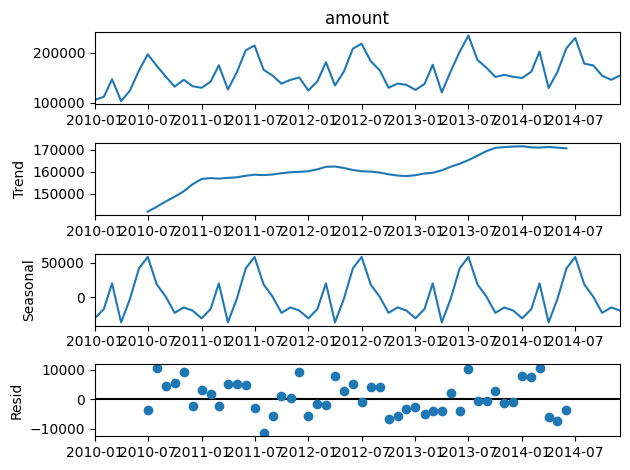

In [806]:
res = sm.tsa.seasonal_decompose(df["amount"])
fig = res.plot()
#本当は差分系列や対数差分系列など、細かい確認が必要

In [807]:
# 学習と評価データに分割
df_train = df[df.index < '2014-01-01']
df_test = df[df.index >= '2014-01-01']

ts = df.amount
ts_train = df_train.amount
ts_test = df_test.amount


In [808]:
import itertools
 
# 各パラメータの範囲を決める
p = d = q = range(0, 3)
sp = sd = sq = range(0, 2)
 
# p, d, q　の組み合わせを列挙するリストを作成
pdq = list(itertools.product(p, d, q))
 
# P, D, Q　の組み合わせを列挙するリストを作成すると同時に、後ろに　s = 12　を決め打ちでつけている。
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))]

In [809]:
# import warnings
 
# warnings.filterwarnings("ignore") # warnings を表示させないようにする

# mape_min = 100
# best_result = [0, 0, 10000000]
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = SARIMAX(ts_train,
#                           order = param,
#                           seasonal_order=param_seasonal,
#                           enforce_stationarity=True,
#                           enforce_invertibility=True)
 
#             results = mod.fit()

#             test_pred = results.forecast(len(ts_test))
#             df_pred = pd.DataFrame(test_pred)  #予測値をdfへ
#             df_pred_reset = df_pred.reset_index()  
#             df_test_reset = df_test.reset_index()

#             MAPE = 0
#             for i in range(len(df_test_reset)):
#                 MAPE +=  np.abs(  df_test_reset.iloc[i,1] -   df_pred_reset.iloc[i,1]  )  / df_test_reset.iloc[i,1]  * 100
#             MAPE /= len(df_test_reset)
             
#             #print('order{}, s_order{} - AIC: {}'.format(param, param_seasonal, results.aic))
#             print('order{}, s_order{} - AIC: {} - MAPE: {}'.format(param, param_seasonal,results.aic, MAPE))
 
#             if MAPE < best_result[2]:
#                 best_result = [param, param_seasonal, MAPE]
#         except:
#             continue
             
# print('MAPEが最も良いモデル:', best_result)


In [810]:
def eval_model(ts_train, ts_test, result):
    train_pred = result.predict()
    test_pred = result.forecast(len(ts_test))
    test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

    train_rmse = np.sqrt(mean_squared_error(ts_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(ts_test, test_pred))
    print('RMSE(train):\t{:.5}\nRMSE(test):\t{:.5}'.format(
        train_rmse, test_rmse))
    return train_pred, test_pred, test_pred_ci
    
    

In [811]:
# order=(4,1,3)
# seasonal_order=(1,1,1,12)
order=(2,0,0)
seasonal_order=(1,0,0,12)

model = SARIMAX(
    ts_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False)
result = model.fit()
train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
#result.summary()


RMSE(train):	3.4742e+04
RMSE(test):	1.0381e+04


In [812]:

train_pred = result.predict()
test_pred = result.forecast(len(ts_test))
test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

train_rmse = np.sqrt(mean_squared_error(df_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(df_test, test_pred))
print('RMSE(train): {:.5}\nRMSE(test): {:.5}'.format(train_rmse, test_rmse))


RMSE(train): 3.4742e+04
RMSE(test): 1.0381e+04


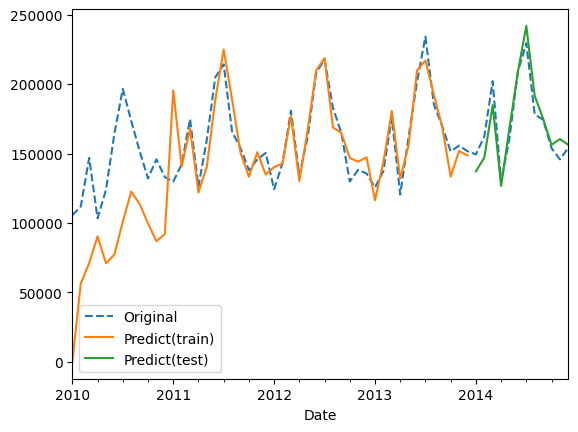

In [813]:

fig, ax = plt.subplots()
df.amount.plot(ax=ax, label='Original', linestyle="dashed")
train_pred.plot(ax=ax, label='Predict(train)')
test_pred.plot(ax=ax, label='Predict(test)')
# ax.fill_between(
#     test_pred_ci.index,
#     test_pred_ci.iloc[:, 0],
#     test_pred_ci.iloc[:, 1],
#     color='k',
#     alpha=.2)
ax.legend()

In [814]:
sarima_pred = result.predict('2015-01-01', '2016-03-01') 


In [815]:

# plt.figure(figsize=(8, 4))
# plt.plot(df.amount, label="original")
# plt.plot(sarima_pred, c="b", label="model-pred", alpha=0.7)
# plt.legend(loc='best')


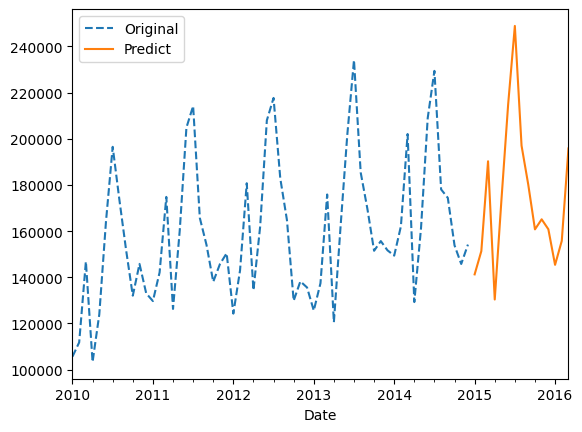

In [816]:
fig, ax = plt.subplots()
df.amount.plot(ax=ax, label='Original', linestyle="dashed")
sarima_pred.plot(ax=ax, label='Predict')
ax.legend()

In [817]:
df_sarima_pred = pd.DataFrame(sarima_pred)
df_sarima_pred_reset = df_sarima_pred.reset_index()
df_sarima_pred_reset['Item'] ='PAC_TOTAL'
df_sarima_pred_reset = df_sarima_pred_reset.rename(columns={'index': 'Date'  , 'predicted_mean':'amount_forecast'})
print(df_sarima_pred_reset)
df_sarima_pred_reset.to_csv('a.csv' , index=False)


         Date  amount_forecast       Item
0  2015-01-01    141268.956158  PAC_TOTAL
1  2015-02-01    151354.574754  PAC_TOTAL
2  2015-03-01    190273.716821  PAC_TOTAL
3  2015-04-01    130383.695321  PAC_TOTAL
4  2015-05-01    173588.573475  PAC_TOTAL
5  2015-06-01    214917.853793  PAC_TOTAL
6  2015-07-01    248907.610297  PAC_TOTAL
7  2015-08-01    197028.121881  PAC_TOTAL
8  2015-09-01    180158.304077  PAC_TOTAL
9  2015-10-01    160770.132539  PAC_TOTAL
10 2015-11-01    165125.835438  PAC_TOTAL
11 2015-12-01    160818.035968  PAC_TOTAL
12 2016-01-01    145398.520919  PAC_TOTAL
13 2016-02-01    155778.549076  PAC_TOTAL
14 2016-03-01    195834.843637  PAC_TOTAL
